In [34]:
# 载入 Python 依赖库
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

import numpy as np
import pandas as pd

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torchtext
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
print(f"torch.__version__ = {torch.__version__}")
print(f"torchtext.__version__ = {torchtext.__version__}")

from torchkeras.kerasmodel import KerasModel
from torchkeras.metrics import Accuracy
from torchkeras.utils.plot_metrics import plot_metrics

torch.__version__ = 1.9.1
torchtext.__version__ = 0.10.1


In [14]:
# 全局变量
MIN_FREQ = 30  # 仅考虑词频超过 30 的词
MAX_LEN = 200  # 每个样本保留 200 个词的长度
BATCH_SIZE = 20

In [15]:
# 数据读取
df_train = pd.read_csv(
    "./data/imdb/train.tsv", 
    sep = "\t", 
    header = None, 
    names = ["label", "text"]
)
df_validate = pd.read_csv(
    "./data/imdb/test.tsv", 
    sep = "\t", 
    header = None, 
    names = ["label", "text"]
)

In [16]:
# 文本切词
tokenizer = get_tokenizer("basic_english")

In [17]:
# 构建词典
PAD_IDX = 0
UNK_IDX = 1
special_symbols = ["<pad>", "<unk>"]

def yield_tokens(df_data):
    for text in df_data["text"]:
        yield tokenizer(text)

vocab = build_vocab_from_iterator(
    yield_tokens(df_train),
    min_freq = MIN_FREQ,
    specials = special_symbols,
    special_first = True,
)
vocab.set_default_index(UNK_IDX)
vocab_size = len(vocab)
print(f"vocab_size = {str(vocab_size)}")
print(f"vocab.get_itos()={vocab.get_itos()[:20]}")  # 查看词典前20个词, itos: index to string
print(f"vocab.get_stoi()={vocab.get_stoi()['<pad>']}")  # stoi: string to index

vocab_size = 8813
vocab.get_itos()=['<pad>', '<unk>', 'the', '.', ',', 'and', 'a', 'of', 'to', "'", 'is', 'it', 'in', 'i', 'this', 'that', 's', 'was', 'as', 'for']
vocab.get_stoi()=0


In [18]:
# 序列填充
def pad(seq, max_length, pad_value = 0):
    n = len(seq)
    result = seq +[pad_value] * max_length
    return result[:max_length]

# 编码转换
def text_pipeline(text):
    words = tokenizer(text)
    tokens = vocab(words)
    result = pad(tokens, MAX_LEN, PAD_IDX)
    return result


print(text_pipeline("this is an example!"))

[14, 10, 41, 461, 36, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [26]:
# 构建数据管道
class ImdbDataset(Dataset):
    def __init__(self, df):
        self.df = df
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        text = self.df["text"].iloc[index]
        label = torch.tensor([
            self.df["label"].iloc[index]
        ]).float()
        tokens = torch.tensor(
            text_pipeline(text)
        ).int()
        return tokens, label

ds_train = ImdbDataset(df_train)
ds_validate = ImdbDataset(df_validate)

dl_train = DataLoader(ds_train, batch_size = 50, shuffle = True)
dl_validate = DataLoader(ds_validate, batch_size = 50, shuffle = False)

In [27]:
# 定义模型
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        
        # 设置 padding_idx 参数后将在训练过程中将填充的 token 始终赋值为 0 向量
        self.embedding = nn.Embedding(num_embeddings = vocab_size, embedding_dim = 3, padding_idx = 0)
        
        self.conv = nn.Sequential()
        self.conv.add_module("conv_1", nn.Conv1d(in_channels = 3, out_channels = 16, kernel_size = 5))
        self.conv.add_module("pool_1", nn.MaxPool1d(kernel_size = 2))
        self.conv.add_module("relu_1", nn.ReLU())
        self.conv.add_module("conv_2", nn.Conv1d(in_channels = 16, out_channels = 128, kernel_size = 2))
        self.conv.add_module("pool_2", nn.MaxPool1d(kernel_size = 2))
        self.conv.add_module("relu_2", nn.ReLU())
        
        self.dense = nn.Sequential()
        self.dense.add_module("flatten", nn.Flatten())
        self.dense.add_module("linear", nn.Linear(6144, 1))
    
    def forward(self, x):
        x = self.embedding(x).transpose(1, 2)
        x = self.conv(x)
        y = self.dense(x)
        return y

net = Net()
print(net)

Net(
  (embedding): Embedding(8813, 3, padding_idx=0)
  (conv): Sequential(
    (conv_1): Conv1d(3, 16, kernel_size=(5,), stride=(1,))
    (pool_1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (relu_1): ReLU()
    (conv_2): Conv1d(16, 128, kernel_size=(2,), stride=(1,))
    (pool_2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (relu_2): ReLU()
  )
  (dense): Sequential(
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (linear): Linear(in_features=6144, out_features=1, bias=True)
  )
)


In [36]:
# 模型训练
model = KerasModel(
    net = net,
    loss_fn = nn.BCEWithLogitsLoss(),
    optimizer = torch.optim.Adam(net.parameters(), lr = 0.01),
    metrics_dict = {"acc": Accuracy()},
)
history_df = model.fit(
    train_data = dl_train,
    validate_data = dl_validate,
    epochs = 10,
    ckpt_path = "./torchcheckpoint/checkpoint.pt",
    patience = 3,
    monitor = "val_acc",
    mode = "max",
)

/Users/zfwang/.pyenv/versions/3.7.10/envs/pytorch/lib/python3.7/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (Accuracy). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_full_state_property`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if `full_state_update=False` can be used safely.
                
  warnings.warn(*args, **kwargs)
  1%|          | 3/400 [00:00<00:15, 24.89it/s, train_acc=0.98, train_loss=0.116]


================================================================================2022-08-30 22:19:22
Epoch 1 / 10



100%|██████████| 100/100 [00:01<00:00, 58.95it/s, val_acc=0.814, val_loss=0.521]
<<<<<< reach best val_acc : 0.8140000104904175 >>>>>>
  1%|          | 3/400 [00:00<00:13, 28.56it/s, train_acc=0.9, train_loss=0.237] 


================================================================================2022-08-30 22:19:37
Epoch 2 / 10



  1%|          | 3/400 [00:00<00:16, 23.87it/s, train_acc=0.98, train_loss=0.0979]


================================================================================2022-08-30 22:19:52
Epoch 3 / 10



100%|██████████| 100/100 [00:01<00:00, 56.99it/s, val_acc=0.815, val_loss=0.564]
<<<<<< reach best val_acc : 0.8151999711990356 >>>>>>
  1%|          | 3/400 [00:00<00:15, 26.02it/s, train_acc=0.96, train_loss=0.0883]


================================================================================2022-08-30 22:20:07
Epoch 4 / 10



  1%|          | 3/400 [00:00<00:15, 25.78it/s, train_acc=0.98, train_loss=0.0742]


================================================================================2022-08-30 22:20:22
Epoch 5 / 10



  1%|          | 3/400 [00:00<00:15, 25.65it/s, train_acc=0.98, train_loss=0.0465]


================================================================================2022-08-30 22:20:37
Epoch 6 / 10



100%|██████████| 100/100 [00:01<00:00, 59.23it/s, val_acc=0.798, val_loss=0.766]
<<<<<< val_acc without improvement in 3 epoch, early stopping >>>>>>


In [37]:
# 评估模型
history_df

,train_loss,train_acc,val_loss,val_acc,epoch
0,0.196584,0.92460,0.520719,0.8140,1
1,0.175541,0.93420,0.520311,0.8096,2
2,0.154345,0.94475,0.563911,0.8152,3
3,0.136470,0.94920,0.619409,0.8104,4
4,0.117021,0.95950,0.693779,0.8082,5
5,0.103967,0.96460,0.765736,0.7980,6


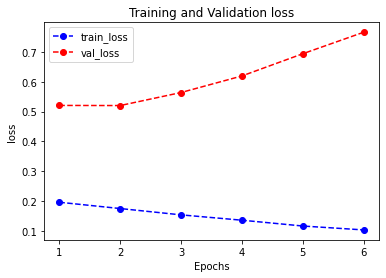

In [38]:
plot_metrics(history_df, "loss")

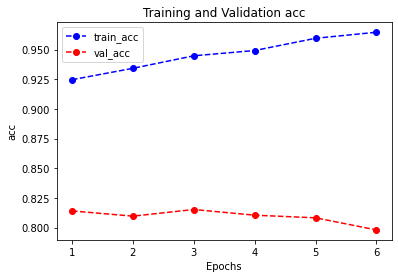

In [39]:
plot_metrics(history_df, "acc")

In [40]:
model.evaluate(dl_validate)

100%|██████████| 100/100 [00:01<00:00, 56.67it/s, val_acc=0.815, val_loss=0.564]


{'val_loss': 0.563910961151123, 'val_acc': 0.8151999711990356}

In [43]:
# 使用模型
y_pred_probs = model.predict(dl_validate)
y_pred_probs

tensor([[ 4.1595],
        [ 3.4210],
        [ 3.3750],
        ...,
        [ 4.0610],
        [-3.4700],
        [ 4.5271]])

In [44]:
# 保存模型
net_clone = Net()
net_clone.load_state_dict(
    torch.load("./torchcheckpoint/checkpoint.pt")
)

<All keys matched successfully>